In [1]:
import numpy as np
import random
import torch
from matplotlib import pyplot as plt
from math import *
from itertools import chain
import torch
import torch.nn as nn
from math import *


### Define variables

In [2]:
sigma_noise_utils = [0.005, 0.005]
#image_size_utils = (400, 300)
nbr_inliers_utils=300
nbr_outliers_utils=200
threshold_inliers = 2

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


### Generate Data

In [3]:
def generate_line():
    a = random.uniform(-10, 10)
    p = random.uniform(0, 1), random.uniform(0,1)
    b = p[1] - a*p[0]
    return (a, b)

def compute_line_from_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    if (x2-x1) != 0:
        a = (y2-y1)/(x2-x1)
    else:
        a = 1000
    b = y1 - a*x1
    return (a, b)
    

def generate_data(line, sigma, n_inliers, n_outliers):
    a, b = line
    L_X = []
    L_Y = []
    #for x in range(image[0]):
    #    y = a*x+b
    #    if y >= 0 and y < image[1]:
    #        p = np.array([x, y])
    #        Points.append(p)
    #covariance = np.diag(np.array(sigma) ** 2)
    #n_i = max(1, n_inliers // len(Points))
    #for point in Points:
    #    sample = np.random.multivariate_normal(point, covariance, n_i)
    #    sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
    #    sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
    #    L_X.extend(sample_X)
    #    L_Y.extend(sample_Y)
    points = []
    if a >= 0:
        L = [(0, b), (-b/a, 0), ((1-b)/a, 1), (1, a+b)]
    else:
        L = [(0, b), ((1-b)/a, 1), (-b/a, 0), (1, a+b)]
    for (x, y) in L:
        if (x >= 0 and x <= 1 and y >= 0 and y <= 1):
            points.append((x, y))
    if len(points) != 2:
        print(L)
        print(points)
        fig, ax = plt.subplots()
        plot_line(line, ax)
    assert (len(points)==2)
    p1, p2 = points[0], points[1]
    #print(p1, p2)
    u = (1, a)
    t = 0.
    #points_lines_x = []
    #points_lines_y = []
    for i in range(n_inliers):
        p = (1-t)*p1[0]+t*p2[0], (1-t)*p1[1]+t*p2[1]
        #points_lines_x.append(p[0])
        #points_lines_y.append(p[1])
        t += 1./n_inliers
        noise = np.random.normal(0, sigma, 2)
        p += noise
        L_X.append(p[0])
        L_Y.append(p[1])
    #fig, ax = plt.subplots()
    #ax.set_xlim(0, 1)
    #ax.set_ylim(0, 1)
    #plot_line(line, ax)
    #plot_data((points_lines_x, points_lines_y), ax)
    #circle_1 = plt.Circle(p1, 0.01, color='r')
    #circle_2 = plt.Circle(p2, 0.01, color='g')
    #ax.add_artist(circle_1)
    #ax.add_artist(circle_2)
    
    
    for k in range(n_outliers):
        (x, y) = random.uniform(0, 1), random.uniform(0,1)
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)

def plot_data(D, ax, c=None):
    L_x, L_y = D
    ax.plot(L_x, L_y, '.', c=c)

def plot_line(line, ax, c=None):
    a, b = line
    X = []
    Y = []
    x = 0
    for k in range(500):
        y = a*x+b
        if y >= 0 and y < 1:
            X.append(x)
            Y.append(y)
        x += 1./500.
    ax.plot(X, Y, c=c)

In [4]:
def generate_data_multi_lines(lines, sigma, n_inliers, n_outliers):
    L_X = []
    L_Y = []
    index_inliers = []
    for (a, b) in lines:
        #Points = []
        #for x in range(image[0]):
        #    y = a*x+b
        #    if y >= 0 and y < image[1]:
        #        p = np.array([x, y])
        #        Points.append(p)
        #covariance = np.diag(np.array(sigma) ** 2)
        #n_i = max(1, n_inliers // len(Points))
        #for point in Points:
        #    sample = np.random.multivariate_normal(point, covariance, n_i)
        #    sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
        #    sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
        #    L_X.extend(sample_X)
        #    L_Y.extend(sample_Y)
        #index_inliers.append(len(L_X))
        points = []
        if a >= 0:
            L = [(0, b), (-b/a, 0), ((1-b)/a, 1), (1, a+b)]
        else:
            L = [(0, b), ((1-b)/a, 1), (-b/a, 0), (1, a+b)]
        for (x, y) in L:
            if (x >= 0 and x <= 1 and y >= 0 and y <= 1):
                points.append((x, y))
        assert (len(points)==2)
        p1, p2 = points[0], points[1]
        #print(p1, p2)
        t = 0
        for i in range(n_inliers):
            p = (1-t)*p1[0]+t*p2[0], (1-t)*p1[1]+t*p2[1]
            t += 1. / n_inliers
            noise = np.random.normal(0, sigma, 2)
            p += noise
            L_X.append(p[0])
            L_Y.append(p[1])
        index_inliers.append(len(L_X))

    for k in range(n_outliers):
        (x, y) = random.uniform(0, 1), random.uniform(0,1)
        L_X.append(x)
        L_Y.append(y)
    
    return ((L_X, L_Y), index_inliers)


def plot_lines(lines, ax, c=None):
    for (a, b) in lines:
        X = []
        Y = []
        x = 0
        for k in range(500):
            y = a*x+b
            if y >= 0 and y < 1:
                X.append(x)
                Y.append(y)
            x += 1./500.
        ax.plot(X, Y, c=c)

(-9.217319339039962, 1.9760329823467429)
250


C:\Users\bcourant\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


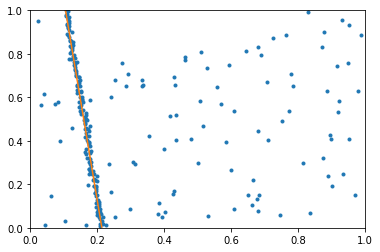

In [5]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line = generate_line()
print(line)
D = generate_data(line, sigma_noise_utils, 150, 100)
plot_data(D, ax)
plot_line(line, ax)
fig.show()
#print(D)
print(len(D[0]))

[(-0.19968959790668883, 0.5531810506922705), (7.5165805146605145, -5.17401632011293), (6.409072552300248, -0.7680021756534512)]
400


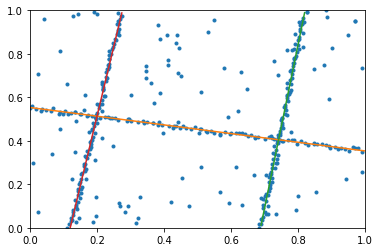

In [6]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
lines = []
for k in range(3):
     lines.append(generate_line())
print(lines)
D, index_inliers = generate_data_multi_lines(lines, sigma_noise_utils, 100, 100)
plot_data(D, ax)
plot_lines(lines, ax)
fig.show()
#print(D)
print(len(D[0]))

### Loss between 2 lines - area

In [7]:
comment = '''def point_y_in_image(l, x, image_y):
    a, b = l
    y = int(a*x+b)
    y = min(max(y, 0), image_y-1)
    return y

def intersect(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    if a1 == a2:
        return False
    else:
        x = (b2 - b1)/(a1-a2)
        y = a1*x+b1
        if x >= 0 and x < image[0] and y >= 0 and y < image[1]:
            return True
        else:
            return False

def change_sign(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    d1 = b1 - b2
    x = image[0]
    d2 = (a1*x+b1)-(a2*x+b2)
    if d1*d2 < 0:
        return True
    else:
        return False

def loss_weights(l1, l2, image):
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
    area2 = image[0]*image[1] - area1
    
    inter = intersect(l1, l2, image)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1
    #print("area final = ", area)
    area = 1 - (area/(image[0]*image[1]))
    return area

def plot_loss(l1, l2, image, ax):
    plot_line(l1, image, ax)
    plot_line(l2, image, ax)
    area_X = []
    area_Y = []
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
        for k in range(min(y1, y2), max(y1, y2)):
            area_X.append(x/image[0])
            area_Y.append(k/image[1])
    ax.plot(area_X, area_Y, '.')
    print(area1)
    area2 = image[0]*image[1] - area1
    print(area2)
    
    inter = intersect(l1, l2, image)
    print(inter)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        print(sign)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1

    area = 1 - (area/(image[0]*image[1])) 
    print("area final = ", area)

    fig.show()
    
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line1 = generate_line(image_size_utils)
print(line1)

line2 = generate_line(image_size_utils)
print(line2)
plot_loss(line1, line2, image_size_utils, ax)'''

### Loss between 2 lines - distance to inliers

In [8]:
def sigmoid(x):
    return ((1/(1+exp(-x)))-0.5)*2

In [9]:
def dist_to_line(p, l):
    a, b = l
    x, y = p
    d = ((a*x+b) - y)/sqrt(1+a*a)
    return d

def dist_points_to_line(data, line, n_inliers):
    X, Y = data[0][:n_inliers], data[1][:n_inliers]
    dist = 0
    for i in range(len(X)):
        p = X[i], Y[i]
        dp = dist_to_line(p, line)
        dist += dp**2
    return dist

def loss_dist_points(data, line, dist_ref, n_inliers):
    dist = dist_points_to_line(data, line, n_inliers)
    return dist_ref/dist

def loss_dist_points_sigmoid(data, line, dist_ref, n_inliers):
    dist = dist_points_to_line(data, line, n_inliers)
    return sigmoid(dist_ref/dist)

In [10]:
def dist_ref_multi_line(data, index_inliers, lines):
    n = len(lines)
    #print(len(lines), len(index_inliers))
    if len(lines) != len(index_inliers):
        print(len(lines), len(index_inliers))
    assert len(lines) == len(index_inliers)
    #print(index_inliers)
    dist_ref = []
    for k in range(n):
        line = lines[k]
        dist = 0
        if k == 0:
            start = 0
        else:
            start = index_inliers[k-1]
        end = index_inliers[k]
        for i in range(start, end):
            p = data[0][i], data[1][i]
            dp = dist_to_line(p, line)
            dist += dp**2
        dist_ref.append(dist)
    return dist_ref

def loss_dist_point_multi(data, line, dist_ref, index_inliers, print_dist=False):
    n = len(index_inliers)
    all_dist = []
    dist_min = -1
    index_min = -1
    for k in range(n):
        dist = 0
        if k == 0:
            start = 0
        else:
            start = index_inliers[k-1]
        end = index_inliers[k]
        for i in range(start, end):
            p = data[0][i], data[1][i]
            dp = dist_to_line(p, line)
            dist += dp**2
        if dist_min == -1 or dist < dist_min:
            dist_min = dist
            index_min = k
        all_dist.append(dist)
    #if print_dist and len(all_dist) > 1:
        #print(all_dist)
    return dist_ref[index_min]/dist_min

def loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers, print_dist=False):
    n = len(index_inliers)
    all_dist = []
    dist_min = -1
    index_min = -1
    for k in range(n):
        dist = 0
        if k == 0:
            start = 0
        else:
            start = index_inliers[k-1]
        end = index_inliers[k]
        for i in range(start, end):
            p = data[0][i], data[1][i]
            dp = dist_to_line(p, line)
            dist += dp**2
        if dist_min == -1 or dist < dist_min:
            dist_min = dist
            index_min = k
        all_dist.append(dist)
    #if print_dist and len(all_dist) > 1:
        #print(all_dist)
    return sigmoid(dist_ref[index_min]/dist_min)
    #return 1-sigmoid(dist_min)

                

### Compute neighborhood

In [11]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return sqrt((x1-x2)**2+(y1-y2)**2)

def reorder(L, M):
    p = L[-1]
    d = M[-1]
    k = len(L) - 2
    while k >= 0 and M[k] > d:
        L[k+1] = L[k]
        M[k+1] = M[k]
        k -= 1
    L[k+1] = p
    M[k+1] = d

def nearest_neighbors(data, i, k):
    p = (data[0][i], data[1][i])
    L = []
    M = []
    n = len(data[0])
    for j in range(n):
        (x, y) = (data[0][j], data[1][j])
        d = dist((x, y), p)
        if len(L) < k:
            L.append((x, y))
            M.append(d)
            reorder(L, M)
        else:
            d2 = M[-1]
            if d < d2:
                L[-1] = (x, y)
                M[-1] = d
                reorder(L, M)
    #print(L)
    return L

def get_neighborhood_patch(data, k, size, scale=(1, 1), nbr_points_all=[]):
    scale_x, scale_y = scale
    size_x, size_y = size
    n = len(data[0])
    (x, y) = data[0][k], data[1][k]
    L = [[0]*(2*size_x+1) for _ in range(2*size_y+1)]
    nbr_points = 0
    for i in range(n):
        (xb, yb) = data[0][i], data[1][i]
        dx = xb-x
        if abs(dx) < scale_x/2.:
            lx = 0
        elif dx >=scale_x/2:
            dx = dx - scale_x/2.
            lx = floor(dx/scale_x)+1
        elif dx <= -scale_x/2:
            dx = dx + scale_x/2.
            lx = floor(dx/scale_x)
        lx += size_x
        
        dy = yb-y
        if abs(dy) < scale_y/2.:
            ly = 0
        elif dy >scale_y/2:
            dy = dy - scale_y/2.
            ly = floor(dy/scale_y)+1
        elif dy <= -scale_y/2:
            dy = dy + scale_y/2.
            ly = floor(dy/scale_y)
        ly += size_y
        
        
        if lx >= 0 and lx < 2*size_x+1 and ly >= 0 and ly < 2*size_y+1:
            L[2*size_y - ly][lx] += 1
            nbr_points += 1
            
            
            
    for i in range(len(L)):
        for j in range(len(L[0])):
            r = L[i][j]
            L[i][j] = [r]
            
    nbr_points_all.append(nbr_points)    
    return L

def get_neighbors_radius(data, k, radius):
    radius_x, radius_y = radius
    n = len(data[0])
    L = []
    (x, y) = (data[0][k], data[1][k])
    for i in range(n):
        (xb, yb) = data[0][i], data[1][i]
        if (abs(xb-x) < radius_x and abs(yb-y) < radius_y):
            L.append([xb, yb])
    return L

In [12]:
line = generate_line()
data = generate_data(line, sigma_noise_utils, 200, 50)

In [13]:
def plot_neighborhood_patch(data, k, size, scale=(0.01, 0.01)):
    scale_x, scale_y = scale
    size_x, size_y = size
    n = len(data[0])
    (x, y) = data[0][k], data[1][k]
    L = [[0]*(2*size_x+1) for _ in range(2*size_y+1)]
    (L_x, L_y) = ([], [])
    for i in range(n):
        (xb, yb) = data[0][i], data[1][i]
        dx = xb-x
        if abs(dx) < scale_x/2.:
            lx = 0
        elif dx >=scale_x/2.:
            dx = dx - scale_x/2.
            lx = floor(dx/scale_x)+1
        elif dx <= -scale_x/2.:
            dx = dx + scale_x/2.
            lx = floor(dx/scale_x)
        lx += size_x
        
        dy = yb-y
        if abs(dy) < scale_y/2.:
            ly = 0
        elif dy >=scale_y/2.:
            dy = dy - scale_y/2.
            ly = floor(dy/scale_y)+1
        elif dy <= -scale_y/2.:
            dy = dy + scale_y/2.
            ly = floor(dy/scale_y)
        ly += size_y
        
        
        if lx >= 0 and lx < 2*size_x+1 and ly >= 0 and ly < 2*size_y+1:
            L[2*size_y - ly][lx] += 1
            L_x.append(xb)
            L_y.append(yb)
            
            
    for i in range(len(L)):
        for j in range(len(L[0])):
            r = L[i][j]
            L[i][j] = [r]

    return (L_x, L_y, L)

[[0], [1], [2], [0], [0]]
[[0], [0], [1], [0], [0]]
[[0], [1], [2], [0], [0]]
[[0], [2], [0], [0], [0]]
[[0], [0], [1], [0], [0]]
0.3551974303427042 0.11136061586772257
0.33019743034270416 0.3801974303427042
0.08636061586772256 0.13636061586772258


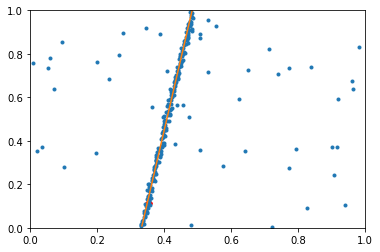

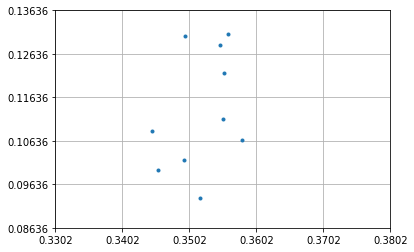

In [14]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
#ax.xaxis.set_ticks(np.arange(0, 1, (2./image_size_utils[0])))
#ax.yaxis.set_ticks(np.arange(0, 1, (2./image_size_utils[1])))
plot_data(data, ax)
plot_line(line, ax)
k = np.random.randint(len(data[0]))
scale = (0.01, 0.01)
size = (2, 2)
L_x, L_y, L = plot_neighborhood_patch(data, k, size, scale=scale)
#L = get_neighbors_radius(data, k, image_size, (5, 5))
for x in L:
    print(x)
circle_1 = plt.Circle((data[0][k], data[1][k]), 0.01, color='r')
px, py = data[0][k], data[1][k]
print(px, py)
ax.add_artist(circle_1)
#plt.grid()
fig.show()
#plt.savefig('test.png')

fig2, ax2 = plt.subplots()
(min_x, max_x) = px - (size[0]*scale[0] + scale[0]/2.), px + size[0]*scale[0] + scale[0]/2.
(min_y, max_y) = py - (size[1]*scale[1] + scale[1]/2.), py + size[1]*scale[1] + scale[1]/2.
print(min_x, max_x)
print(min_y, max_y)
ax2.xaxis.set_ticks(np.arange(min_x, max_x, scale[0]))
ax2.yaxis.set_ticks(np.arange(min_y, max_y, scale[1]))
ax2.set_xlim(min_x, max_x)
ax2.set_ylim(min_y, max_y)
ax2.plot(L_x, L_y, '.')
plt.grid()
fig2.show()

### Compute feature & Generate data

In [15]:
def center_points(points, p):
    (x, y) = p
    L = []
    for point in points:
        (xp, yp) = point
        L.append([xp-x, yp-y])
    return L

def compute_features_k(data, i1, i2):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    k = 10
    #print("feature i1:")
    x1 = center_points(nearest_neighbors(data, i1, k), p1)
    #print("feature i2:")
    x2 = center_points(nearest_neighbors(data, i2, k), p2)
    feature = x1+x2
    feature.append(vec)
    feature.append([p1[0], p1[1]])
    feature.append([p2[0], p2[1]])
    return feature

def compute_features_patch(data, i1, i2, size_patch, scale = (0.005, 0.005), L = []):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    x1 = get_neighborhood_patch(data, i1, size_patch, scale, L)
    x2 = get_neighborhood_patch(data, i2, size_patch, scale, L)
    feature1 = x1
    feature2 = x2
    feature3 = []
    feature3.append(vec)
    feature3.append([p1[0], p1[1]])
    feature3.append([p2[0], p2[1]])
    return (feature1, feature2, feature3)

def compute_features_radius(data, i1, i2):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    radius = (5, 5)
    x1 = center_points(get_neighbors_radius(data, i1, radius), p1)
    x2 = center_points(get_neighbors_radius(data, i2, radius), p2)
    feature1 = x1
    feature2 = x2
    feature3 = []
    feature3.append(vec)
    feature3.append([p1[0], p1[1]])
    feature3.append([p2[0], p2[1]])
    return (feature1, feature2, feature3)
    

def generate_training_data(sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers_range, loss = 1, split=0.9):
    Lines = []
    Datas = []
    X = []
    Y = []
    nbr_outliers_all = []
    points_all = []
    y_test_v2 = []
    Lines_valid = []
    Datas_valid = []
    X_valid = []
    Y_valid = []
    nbr_outliers_all_valid = []
    points_all_valid = []
    y_test_v2_valid = []
    for k in range(nbr):
        line_ref = generate_line()
        n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
        data = generate_data(line_ref, sigma, nbr_inliers, n_outliers)
        n_inliers_precise = len(data[0]) - n_outliers
        dist_ref = dist_points_to_line(data, line_ref, n_inliers_precise)
        if (k+1)/nbr <= split:
            nbr_outliers_all.append(n_outliers)
            Datas.append(data)
            Lines.append(line_ref)
        else:
            nbr_outliers_all_valid.append(n_outliers)
            Datas_valid.append(data)
            Lines_valid.append(line_ref)
        nbr_points = len(data[0])
        y_test = []
        points = []
        for i in range(nbr_per_line[0]):
            i1 = np.random.randint(nbr_points)
            if nbr_per_line[0]==1:
                i1 = np.random.randint(n_inliers_precise)
            
            L = [k for k in range(nbr_points) if k!=i1]
            random.shuffle(L)
            for j in range(nbr_per_line[1]):
                i2 = L[j]
                #i2 = np.random.randint(nbr_points)
                #while i2 == i1:
                #    i2 = np.random.randint(nbr_points)
                feature = compute_features_k(data, i1, i2)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2)
                #if loss==0:
                #    area = loss_weights(line_ref, line)
                #elif loss==1:
                #area = loss_dist_points(data, line, dist_ref, n_inliers_precise)
                area = loss_dist_points_sigmoid(data, line, dist_ref, n_inliers_precise)
                y_test.append(area)
                points.append((i1, i2))
                if (k+1)/nbr <= split: 
                    Y.append([area])
                    X.append(feature)
                else:
                    Y_valid.append([area])
                    X_valid.append(feature)
        if (k+1)/nbr <= split: 
            points_all.append(points)
            y_test_v2.append(y_test)
        else:
            points_all_valid.append(points)
            y_test_v2_valid.append(y_test)
    #print(len(X1), len(X2), len(X3))
    X_tensor = torch.tensor(X)
    Y_tensor = torch.Tensor(Y)
    X_tensor_valid = torch.tensor(X_valid)
    Y_tensor_valid = torch.Tensor(Y_valid)
    #print(X_nn_tensor.shape)
    
    return ((X_tensor, Y_tensor, Datas, Lines, nbr_outliers_all, points_all, y_test_v2), (X_tensor_valid, Y_tensor_valid, Datas_valid, Lines_valid, nbr_outliers_all_valid, points_all_valid, y_test_v2_valid))

def generate_training_data_patch(sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers_range, size_patch, scale, split=0.9):
    Lines = []
    Datas = []
    nbr_outliers_all = []
    X1, X2, X3 = [], [], []
    Y = []
    points_all = []
    y_test_v2 = []
    Lines_valid = []
    Datas_valid = []
    nbr_outliers_all_valid = []
    X1_valid, X2_valid, X3_valid = [], [], []
    Y_valid = []
    points_all_valid = []
    y_test_v2_valid = []
    nbr_points_in_patch = []
    for k in range(nbr):
        line_ref = generate_line()
        n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
        data = generate_data(line_ref, sigma, nbr_inliers, n_outliers)
        n_inliers_precise = len(data[0]) - n_outliers
        dist_ref = dist_points_to_line(data, line_ref, n_inliers_precise)
        nbr_points = len(data[0])
        if (k+1)/nbr <= split:
            nbr_outliers_all.append(n_outliers)
            Datas.append(data)
            Lines.append(line_ref)
        else:
            nbr_outliers_all_valid.append(n_outliers)
            Datas_valid.append(data)
            Lines_valid.append(line_ref)
        y_test = []
        points = []
        for i in range(nbr_per_line[0]):
            i1 = np.random.randint(nbr_points)
            if nbr_per_line[0]==1:
                i1 = np.random.randint(n_inliers_precise)
            
            L = [k for k in range(nbr_points) if k!=i1]
            random.shuffle(L)
            for j in range(nbr_per_line[1]):
                i2 = L[j]
                (feature1, feature2, feature3) = compute_features_patch(data, i1, i2, size_patch, scale, nbr_points_in_patch)
    
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2)
                #area = loss_weights(line_ref, line, image)
                #area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
                area = loss_dist_points_sigmoid(data, line, dist_ref, n_inliers_precise)

                if (k+1)/nbr <= split: 
                    Y.append([area])
                    X1.append(feature1)
                    X2.append(feature2)
                    X3.append(feature3)
                else:
                    Y_valid.append([area])
                    X1_valid.append(feature1)
                    X2_valid.append(feature2)
                    X3_valid.append(feature3)
                    
                y_test.append(area)
                points.append((i1, i2))
        if (k+1)/nbr <= split: 
            points_all.append(points)
            y_test_v2.append(y_test)
        else:
            points_all_valid.append(points)
            y_test_v2_valid.append(y_test)
                
    #print(len(X1), len(X2), len(X3))

    Y_tensor = torch.Tensor(Y)
    print(Y_tensor.shape)
    Y_tensor_valid = torch.Tensor(Y_valid)
    print(Y_tensor_valid.shape)
    
    X_tensor1 = torch.Tensor(X1)
    print(X_tensor1.shape)
    X_tensor2 = torch.Tensor(X2)
    print(X_tensor2.shape)
    X_tensor3 = torch.Tensor(X3)
    print(X_tensor3.shape)
    X_tensor1_valid = torch.Tensor(X1_valid)
    print(X_tensor1_valid.shape)
    X_tensor2_valid = torch.Tensor(X2_valid)
    print(X_tensor2_valid.shape)
    X_tensor3_valid = torch.Tensor(X3_valid)
    print(X_tensor3_valid.shape)
    
    nbr_points_in_patch = np.array(nbr_points_in_patch)
    print("----------nbr points in patch -----------")
    print("mean =", np.mean(nbr_points_in_patch))
    print("min / max =", np.min(nbr_points_in_patch), np.max(nbr_points_in_patch))
    
    
    return (((X_tensor1, X_tensor2, X_tensor3), Y_tensor, Datas, Lines, nbr_outliers_all, points_all, y_test_v2), ((X_tensor1_valid, X_tensor2_valid, X_tensor3_valid), Y_tensor_valid, Datas_valid, Lines_valid, nbr_outliers_all_valid, points_all_valid, y_test_v2_valid))


def split_training(xy, prop=0.1):
    (X, Y, Datas, Lines, nbr_outliers_all,points, y_v2) = xy
    k = int(prop*len(X))
    x_test = X[:k]
    y_test = Y[:k]
    data_test = Datas[:k]
    lines_test = Lines[:k]
    outliers_test = nbr_outliers_all[:k]
    points_test = points[:k]
    y_v2_test = y_v2[:k]
    x_train = X[k:]
    y_train = Y[k:]
    data_train = Datas[k:]
    lines_train = Lines[k:]
    outliers_train = nbr_outliers_all[k:]
    points_train = points[k:]
    y_v2_train = y_v2[k:]
    return ((x_test, y_test, data_test, lines_test, outliers_test, points_test, y_v2_test), (x_train, y_train, data_train, lines_train, outliers_train, points_train, y_v2_train))

def split_training_bis(xy, prop=0.1):
    ((X1, X2, X3), Y, Datas, Lines, nbr_outliers_all, points, y_v2) = xy
    k = int(prop*len(X1))
    x_test1 = X1[:k]
    x_test2 = X2[:k]
    x_test3 = X3[:k]
    y_test = Y[:k]   
    data_test = Datas[:k]
    lines_test = Lines[:k]
    outliers_test = nbr_outliers_all[:k]
    points_test = points[:k]
    y_v2_test = y_v2[:k]
    x_train1 = X1[k:]
    x_train2 = X2[k:]
    x_train3 = X3[k:]
    y_train = Y[k:]
    data_train = Datas[k:]
    lines_train = Lines[k:]
    outliers_train = nbr_outliers_all[k:]
    points_train = points[k:]
    y_v2_train = y_v2[k:]

    return (((x_test1, x_test2, x_test3), y_test, data_test, lines_test, outliers_test, points_test, y_v2_test), ((x_train1, x_train2, x_train3), y_train, data_train, lines_train, outliers_train, points_train, y_v2_train))

In [16]:
def generate_training_data_patch_multi_lines(sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range, size_patch, scale, split=0.9):
    Lines = []
    Datas = []
    nbr_outliers_all = []
    index_inliers_all = []
    X1, X2, X3 = [], [], []
    Y = []
    points_all = []
    y_test_v2 = []
    Lines_valid = []
    Datas_valid = []
    nbr_outliers_all_valid = []
    index_inliers_all_valid = []
    X1_valid, X2_valid, X3_valid = [], [], []
    Y_valid = []
    points_all_valid = []
    y_test_v2_valid = []
    nbr_points_in_patch = []

    for k in range(nbr):
        nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
        lines_ref = []
        for _ in range(nbr_lines):
            line_ref = generate_line()
            lines_ref.append(line_ref)
            
        
        n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
        data, index_inliers = generate_data_multi_lines(lines_ref, sigma, nbr_inliers, n_outliers)
        if (k+1)/nbr <= split: 
            nbr_outliers_all.append(n_outliers)
            index_inliers_all.append(index_inliers)
            Datas.append(data)
            Lines.append(lines_ref)
        else:
            nbr_outliers_all_valid.append(n_outliers)
            index_inliers_all_valid.append(index_inliers)
            Datas_valid.append(data)
            Lines_valid.append(lines_ref)
        
        dist_ref =  dist_ref_multi_line(data, index_inliers, lines_ref)
        nbr_points = len(data[0])
        y_test = []
        points = []

        for i in range(nbr_per_line[0]):
            i1 = np.random.randint(nbr_points)
            
            L = [k for k in range(nbr_points) if k!=i1]
            random.shuffle(L)
            for j in range(nbr_per_line[1]):
                i2 = L[j]
                (feature1, feature2, feature3) = compute_features_patch(data, i1, i2, size_patch, scale, nbr_points_in_patch)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2)
                area = loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers)

                if (k+1)/nbr <= split: 
                    Y.append([area])
                    X1.append(feature1)
                    X2.append(feature2)
                    X3.append(feature3)
                else:
                    Y_valid.append([area])
                    X1_valid.append(feature1)
                    X2_valid.append(feature2)
                    X3_valid.append(feature3)
                    
                y_test.append(area)
                points.append((i1, i2))
        if (k+1)/nbr <= split: 
            points_all.append(points)
            y_test_v2.append(y_test)
        else:
            points_all_valid.append(points)
            y_test_v2_valid.append(y_test)
                
    #print(len(X1), len(X2), len(X3))

    Y_tensor = torch.Tensor(Y)
    print(Y_tensor.shape)
    Y_tensor_valid = torch.Tensor(Y_valid)
    print(Y_tensor_valid.shape)
    
    X_tensor1 = torch.Tensor(X1)
    print(X_tensor1.shape)
    X_tensor2 = torch.Tensor(X2)
    print(X_tensor2.shape)
    X_tensor3 = torch.Tensor(X3)
    print(X_tensor3.shape)
    X_tensor1_valid = torch.Tensor(X1_valid)
    print(X_tensor1_valid.shape)
    X_tensor2_valid = torch.Tensor(X2_valid)
    print(X_tensor2_valid.shape)
    X_tensor3_valid = torch.Tensor(X3_valid)
    print(X_tensor3_valid.shape)
    
    nbr_points_in_patch = np.array(nbr_points_in_patch)
    print("----------nbr points in patch -----------")
    print("mean =", np.mean(nbr_points_in_patch))
    print("min / max =", np.min(nbr_points_in_patch), np.max(nbr_points_in_patch))
    
    
    return (((X_tensor1, X_tensor2, X_tensor3), Y_tensor, Datas, Lines, nbr_outliers_all, index_inliers_all, points_all, y_test_v2), ((X_tensor1_valid, X_tensor2_valid, X_tensor3_valid), Y_tensor_valid, Datas_valid, Lines_valid, nbr_outliers_all_valid, index_inliers_all_valid, points_all_valid, y_test_v2_valid))


In [17]:
def generate_training_data_multi_lines(sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range, split=0.9):
    Lines = []
    Datas = []
    X = []
    Y = []
    points_all = []
    y_test_v2 = []
    nbr_outliers_all = []
    index_inliers_all = []
    Lines_valid = []
    Datas_valid = []
    X_valid = []
    Y_valid = []
    points_all_valid = []
    y_test_v2_valid = []
    nbr_outliers_all_valid = []
    index_inliers_all_valid = []
    for k in range(nbr):
        nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
        lines_ref = []
        for _ in range(nbr_lines):
            line_ref = generate_line()
            lines_ref.append(line_ref)
        
        n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
        data, index_inliers = generate_data_multi_lines(lines_ref, sigma, nbr_inliers, n_outliers)
        if (k+1)/nbr <= split: 
            nbr_outliers_all.append(n_outliers)
            index_inliers_all.append(index_inliers)
            Datas.append(data)
            Lines.append(lines_ref)
        else:
            nbr_outliers_all_valid.append(n_outliers)
            index_inliers_all_valid.append(index_inliers)
            Datas_valid.append(data)
            Lines_valid.append(lines_ref)
        
        dist_ref =  dist_ref_multi_line(data, index_inliers, lines_ref)
        nbr_points = len(data[0])
        y_test = []
        points = []
        for i in range(nbr_per_line[0]):
            i1 = np.random.randint(nbr_points)
            if nbr_per_line[0]==1:
                i1 = np.random.randint(index_inliers[-1])
            
            L = [k for k in range(nbr_points) if k!=i1]
            random.shuffle(L)
            for j in range(nbr_per_line[1]):
                i2 = L[j]
                feature = compute_features_k(data, i1, i2)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2)
                area = loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers)
                if (k+1)/nbr <= split: 
                    Y.append([area])
                    X.append(feature)
                else:
                    Y_valid.append([area])
                    X_valid.append(feature)
                    
                y_test.append(area)
                points.append((i1, i2))
                
        if (k+1)/nbr <= split: 
            points_all.append(points)
            y_test_v2.append(y_test)
        else:
            points_all_valid.append(points)
            y_test_v2_valid.append(y_test)
                
    #print(len(X1), len(X2), len(X3))
    X_tensor = torch.tensor(X)
    Y_tensor = torch.Tensor(Y)
    X_tensor_valid = torch.tensor(X_valid)
    Y_tensor_valid = torch.Tensor(Y_valid)
    #print(X_nn_tensor.shape)
    
    return ((X_tensor, Y_tensor, Datas, Lines, nbr_outliers_all, index_inliers_all, points_all, y_test_v2), (X_tensor_valid, Y_tensor_valid, Datas_valid, Lines_valid, nbr_outliers_all_valid, index_inliers_all_valid, points_all_valid, y_test_v2_valid))

def split_training_multi(xy, prop=0.1):
    (X, Y, Datas, Lines, nbr_outliers_all, index_inliers, points, y_v2) = xy
    k = int(prop*len(X))
    x_test = X[:k]
    y_test = Y[:k]
    data_test = Datas[:k]
    lines_test = Lines[:k]
    outliers_test = nbr_outliers_all[:k]
    index_test = index_inliers[:k]
    points_test = points[:k]
    y_v2_test = y_v2[:k]
    x_train = X[k:]
    y_train = Y[k:]
    data_train = Datas[k:]
    lines_train = Lines[k:]
    outliers_train = nbr_outliers_all[k:]
    index_train = index_inliers[k:]
    points_train = points[k:]
    y_v2_train = y_v2[k:]
    return ((x_test, y_test, data_test, lines_test, outliers_test, index_test, points_test, y_v2_test), (x_train, y_train, data_train, lines_train, outliers_train, index_train, points_train, y_v2_train))

### Compute feature & Generate training data for coefLine model

In [7]:
def original_sigmoid(x):
    return 1./(1.+exp(-x))

def loss_label(y_predict, t):
    y = original_sigmoid(y_predict)
    loss = - t*log(y) - (1-t)*log(1-y)
    return loss

def loss_coef(c1, c2, prt=False):
    [y1, u1, v1] = c1
    [y2, u2, v2] = c2
    loss1 = 2*loss_label(y1, y2)
    loss2 = y2*(1-(u1*u2+v1*v2)**2/(u1**2+v1**2)*(u2**2+v2**2))
    if prt:
        print("loss =", loss1, loss2, "label=", y1, original_sigmoid(y1), y2)
    loss = loss1+loss2
    return loss

def loss_coef_list(l1, l2, prt=False):
    loss = 0
    for i in range(len(l1)):
        loss += loss_coef(l1[i].squeeze(), l2[i], prt)
    return loss/len(l1)

In [18]:
def get_line_ref(index_inliers, i1):
    index = 0
    while index < len(index_inliers) and i1 >= index_inliers[index]:
        index += 1
    if index == len(index_inliers):
        index = -1
    return index

In [19]:
def compute_features_patch_coef(data, i1, size_patch, scale = (0.005, 0.005), L=[]):
    p1 = (data[0][i1], data[1][i1])
    x1 = get_neighborhood_patch(data, i1, size_patch, scale, L)
    feature1 = x1
    return feature1

In [20]:
def generate_training_data_patch_coef(sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range, size_patch, scale, split=0.9):
    Lines = []
    Datas = []
    nbr_outliers_all = []
    index_inliers_all = []
    X1 = []
    Y = []
    Lines_valid = []
    Datas_valid = []
    nbr_outliers_all_valid = []
    index_inliers_all_valid = []
    X1_valid = []
    Y_valid = []
    nbr_points_in_patch = []

    for k in range(nbr):
        nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
        lines_ref = []
        for _ in range(nbr_lines):
            line_ref = generate_line()
            lines_ref.append(line_ref)
            
        
        n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
        data, index_inliers = generate_data_multi_lines(lines_ref, sigma, nbr_inliers, n_outliers)
        if (k+1)/nbr <= split: 
            nbr_outliers_all.append(n_outliers)
            index_inliers_all.append(index_inliers)
            Datas.append(data)
            Lines.append(lines_ref)
        else:
            nbr_outliers_all_valid.append(n_outliers)
            index_inliers_all_valid.append(index_inliers)
            Datas_valid.append(data)
            Lines_valid.append(lines_ref)
        
        nbr_points = len(data[0])

        for i in range(nbr_per_line):
            i1 = np.random.randint(nbr_points)
            feature1 = compute_features_patch_coef(data, i1, size_patch, scale, nbr_points_in_patch)
            p1 = (data[0][i1], data[1][i1])
            index_line_ref = get_line_ref(index_inliers, i1)
            if index_line_ref == -1:
                coef = [0, 0, 0]
            else:
                line = lines_ref[index_line_ref]
                u = (1, line[0])
                norm = sqrt(1+line[0]**2)
                coef = [1, 1./norm, line[0]/norm]
            if (k+1)/nbr <= split: 
                Y.append(coef)
                X1.append(feature1)
            else:
                Y_valid.append(coef)
                X1_valid.append(feature1)
                
    #print(len(X1), len(X2), len(X3))

    Y_tensor = torch.Tensor(Y)
    print(Y_tensor.shape)
    Y_tensor_valid = torch.Tensor(Y_valid)
    print(Y_tensor_valid.shape)
    
    X_tensor1 = torch.Tensor(X1)
    print(X_tensor1.shape)
    X_tensor1_valid = torch.Tensor(X1_valid)
    print(X_tensor1_valid.shape)
    
    nbr_points_in_patch = np.array(nbr_points_in_patch)
    print("----------nbr points in patch -----------")
    print("mean =", np.mean(nbr_points_in_patch))
    print("min / max =", np.min(nbr_points_in_patch), np.max(nbr_points_in_patch))
    
    
    return ((X_tensor1, Y_tensor, Datas, Lines, nbr_outliers_all, index_inliers_all), (X_tensor1_valid, Y_tensor_valid, Datas_valid, Lines_valid, nbr_outliers_all_valid, index_inliers_all_valid))


In [25]:
def compute_weights_coef(model, type_model, data, size_patch=None, scale=None, train=False):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])
    X_nn = []
    X1 = []
    coord = []
    for i1 in range(n):
        if type_model == 1:
            feature=compute_features_k_coef(data, i1)
            X_nn.append(feature)
        elif type_model == 2:
            feature1 = compute_features_patch_coef(data, i1, size_patch, scale)
            X1.append(feature1)

        p1 = (data[0][i1], data[1][i1])
            
    if train:
        if type_model == 1:
            X_tensor = torch.Tensor(X_nn)
            weights_predict_train = model(X_tensor.to(DEVICE))
        elif type_model == 2:
            X_tensor1 = torch.Tensor(X1)
            weights_predict_train = model(X_tensor1.to(DEVICE).float())
    
    
    model.eval()
    with torch.no_grad():
        if type_model == 1:
            X_tensor = torch.Tensor(X_nn)
            weights_predict_eval = model(X_tensor.to(DEVICE))
        elif type_model == 2:
            X_tensor1 = torch.Tensor(X1)
            weights_predict_eval = model(X_tensor1.to(DEVICE).float())
       
    if train:
        return weights_predict_train, weights_predict_eval
    else:
        return weights_predict_eval
    
    

def compute_weights_ref_coef(lines_ref, data, index_inliers):
    weights_ref = []
    n = len(data[0])
    k = 0
    for i1 in range(n):
        while k < len(index_inliers) and i1 >= index_inliers[k]:
            k+=1
        if k == len(index_inliers):
            coef = [0, 0, 0]
        else:
            line = lines_ref[k]
            u = (1, line[0])
            norm = sqrt(1+line[0]**2)
            coef = [1, 1./norm, line[0]/norm]
        weights_ref.append(coef)
    return weights_ref

In [26]:
def plot_first_point_coef(data, lines_ref, p1, shape):
    ax = plt.subplot(shape)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    for line in lines:
        plot_line(line, ax)
    circle_1 = plt.Circle(p1, 0.015, color='r')
    ax.add_artist(circle_1)

In [27]:
def plot_weights_coef(coef, data, p1, shape, ref=False):
    ax = plt.subplot(shape)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    circle_1 = plt.Circle(p1, 0.015, color='r')
    ax.add_artist(circle_1)
    if not ref:
        coef[0] = original_sigmoid(coef[0])
    print(coef)
    if coef[0] >= 0.5:
        u, v = coef[1], coef[2]
        a = v/u
        b = p1[1]-a*p1[0]
        plot_line((a, b), ax)
        print("coef line =", a)
    else:
        print("not a line")


In [ ]:
def plot_patch(k, data, size, scale, shape):
    ax = plt.subplot(shape)
    (px, py) = (data[0][k], data[1][k])
    (min_x, max_x) = px - (size[0]*scale[0] + scale[0]/2.), px + size[0]*scale[0] + scale[0]/2.
    (min_y, max_y) = py - (size[1]*scale[1] + scale[1]/2.), py + size[1]*scale[1] + scale[1]/2.
    ax.xaxis.set_ticks(np.arange(min_x, max_x, scale[0]))
    ax.yaxis.set_ticks(np.arange(min_y, max_y, scale[1]))
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    L_x, L_y, L = plot_neighborhood_patch(data, k, size, scale=scale)
    for x in L:
        print(x)
    ax.plot(L_x, L_y, '.')
    plt.grid()

In [28]:
def plot_weights_during_training_patch_coef(model, data, lines_ref, index_inliers, size_patch, scale_patch, nbr_print=1):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])

    weights_predict_train, weights_predict_eval = compute_weights_coef(model, 2, data, size_patch=size_patch, scale=scale_patch, train=True)
    weights_ref_points = compute_weights_ref_coef(lines_ref, data, index_inliers)
    s_eval = sum([loss_coef(weights_predict_train[i].squeeze().tolist(), weights_ref_points[i]) for i in range(len(weights_predict_eval))])
    s_train = sum([loss_coef(weights_predict_train[i].squeeze().tolist(), weights_ref_points[i]) for i in range(len(weights_predict_train))])
    
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)))
    print("loss_norm_train =", (s_train/len(weights_predict_train)))

    
    #weights_predict = torch.Tensor(weights_predict)
    #weights_ref_points = torch.Tensor(weights_ref_points)
    #print("loss_MSE =", loss_fn(weights_predict, weights_ref_points))

    for k in range(nbr_print):
        i = np.random.randint(len(data[0]))
        p1 = data[0][i], data[1][i]
        print("-------------weights ref-----------------")
        plot_weights_coef(weights_ref_points[i], data, p1, 141, ref=True)
        print("-------------weights predict train-----------------")
        plot_weights_coef(weights_predict_train[i].squeeze().tolist(), data, p1, 143)
        print("-------------weights predict eval-----------------")
        plot_weights_coef(weights_predict_eval[i].squeeze().tolist(), data, p1, 144)
        print("-------------------patch------------------------")
        plot_patch(i, data, size_patch, scale_patch, 142)

### Compute feature & Generate training data for patch3D model

In [ ]:
def compute_features_patch_3D(data, i1, i2, size_patch, scale = (0.005, 0.005), L = []):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    x1 = get_neighborhood_patch(data, i1, size_patch, scale, L)
    x2 = get_neighborhood_patch(data, i2, size_patch, scale, L)
    feature1 = [x1, x2]
    feature2 = []
    feature2.append(vec)
    feature2.append([p1[0], p1[1]])
    feature2.append([p2[0], p2[1]])
    return (feature1, feature2)
    

In [ ]:
def compute_weights_patch_3D(model, data, i1, size_patch=None, scale=None, train=False):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])

    p1 = data[0][i1], data[1][i1]
    X_nn = []
    (X1, X2) = ([], [])
    coord = []
    for i2 in range(n):
        if i2!=i1:
            (feature1, feature2) = compute_features_patch_3D(data, i1, i2, size_patch, scale)
            X1.append(feature1)
            X2.append(feature2)

            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2)

            coord.append((data[0][i2], data[1][i2]))
            
    if train:
        X_tensor1 = torch.Tensor(X1).squeeze()
        X_tensor2 = torch.Tensor(X2)
        weights_predict_train = model((X_tensor1.to(DEVICE).float(), X_tensor2.to(DEVICE).float()))
        #weights_predict_train = model(X_tensor1.to(DEVICE).float())

        weights_train = []
        k = 0
        for i in range(n):
            if i == i1:
                weights_train.append(0)
                k = 1
            else:
                weights_train.append(weights_predict_train[i-k][0])

    
        assert len(weights_train) == len(data[0])
    
    
    model.eval()
    with torch.no_grad():
        X_tensor1 = torch.Tensor(X1).squeeze()
        X_tensor2 = torch.Tensor(X2)
        weights_predict_eval = model((X_tensor1.to(DEVICE).float(), X_tensor2.to(DEVICE).float()))
        #weights_predict_eval = model(X_tensor1.to(DEVICE).float())

    weights_eval = []
    k = 0
    for i in range(n):
        if i == i1:
            weights_eval.append(0)
            k = 1
        else:
            weights_eval.append(weights_predict_eval[i-k][0])
    
    
    assert len(weights_eval) == len(data[0])
       
    if train:
        return weights_train, weights_eval
    else:
        return weights_eval

        

In [ ]:
def generate_training_data_patch_3D(sigma, nbr, nbr_per_line, nbr_lines_range, nbr_inliers, nbr_outliers_range, size_patch, scale, split=0.9):
    Lines = []
    Datas = []
    nbr_outliers_all = []
    index_inliers_all = []
    X1, X2, X3 = [], [], []
    Y = []
    points_all = []
    y_test_v2 = []
    Lines_valid = []
    Datas_valid = []
    nbr_outliers_all_valid = []
    index_inliers_all_valid = []
    X1_valid, X2_valid, X3_valid = [], [], []
    Y_valid = []
    points_all_valid = []
    y_test_v2_valid = []
    nbr_points_in_patch = []

    for k in range(nbr):
        nbr_lines = np.random.randint(nbr_lines_range[0], nbr_lines_range[1]+1)
        lines_ref = []
        for _ in range(nbr_lines):
            line_ref = generate_line()
            lines_ref.append(line_ref)
            
        
        n_outliers = np.random.randint(nbr_outliers_range[0], nbr_outliers_range[1]+1)
        data, index_inliers = generate_data_multi_lines(lines_ref, sigma, nbr_inliers, n_outliers)
        if (k+1)/nbr <= split: 
            nbr_outliers_all.append(n_outliers)
            index_inliers_all.append(index_inliers)
            Datas.append(data)
            Lines.append(lines_ref)
        else:
            nbr_outliers_all_valid.append(n_outliers)
            index_inliers_all_valid.append(index_inliers)
            Datas_valid.append(data)
            Lines_valid.append(lines_ref)
        
        dist_ref =  dist_ref_multi_line(data, index_inliers, lines_ref)
        nbr_points = len(data[0])
        y_test = []
        points = []

        for i in range(nbr_per_line[0]):
            i1 = np.random.randint(nbr_points)
            
            L = [k for k in range(nbr_points) if k!=i1]
            random.shuffle(L)
            for j in range(nbr_per_line[1]):
                i2 = L[j]
                (feature1, feature2) = compute_features_patch_3D(data, i1, i2, size_patch, scale, nbr_points_in_patch)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2)
                area = loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers)

                if (k+1)/nbr <= split: 
                    Y.append([area])
                    X1.append(feature1)
                    X2.append(feature2)
                else:
                    Y_valid.append([area])
                    X1_valid.append(feature1)
                    X2_valid.append(feature2)
                    
                y_test.append(area)
                points.append((i1, i2))
        if (k+1)/nbr <= split: 
            points_all.append(points)
            y_test_v2.append(y_test)
        else:
            points_all_valid.append(points)
            y_test_v2_valid.append(y_test)
                
    #print(len(X1), len(X2), len(X3))

    Y_tensor = torch.Tensor(Y)
    print(Y_tensor.shape)
    Y_tensor_valid = torch.Tensor(Y_valid)
    print(Y_tensor_valid.shape)
    
    X_tensor1 = torch.Tensor(X1)
    print(X_tensor1.shape)
    X_tensor2 = torch.Tensor(X2)
    print(X_tensor2.shape)
    X_tensor1_valid = torch.Tensor(X1_valid)
    print(X_tensor1_valid.shape)
    X_tensor2_valid = torch.Tensor(X2_valid)
    print(X_tensor2_valid.shape)
    
    nbr_points_in_patch = np.array(nbr_points_in_patch)
    print("----------nbr points in patch -----------")
    print("mean =", np.mean(nbr_points_in_patch))
    print("min / max =", np.min(nbr_points_in_patch), np.max(nbr_points_in_patch))
    
    
    return (((X_tensor1, X_tensor2), Y_tensor, Datas, Lines, nbr_outliers_all, index_inliers_all, points_all, y_test_v2), ((X_tensor1_valid, X_tensor2_valid), Y_tensor_valid, Datas_valid, Lines_valid, nbr_outliers_all_valid, index_inliers_all_valid, points_all_valid, y_test_v2_valid))


In [ ]:
def plot_weights_during_training_patch_3D(model, data, lines_ref, index_inliers, y_test, points_test, size_patch, scale_patch, loss_fn, scale=100):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])
    #i1 = np.random.randint(n)
    i1 = plot_weights_testing(y_test, data, points_test, 174)
    dist_ref = dist_ref_multi_line(data, index_inliers, lines_ref)
    p1 = (data[0][i1], data[1][i1])


    weights_predict_train, weights_predict_eval = compute_weights_patch_3D(model, data, i1, size_patch=size_patch, scale=scale_patch, train=True)
    weights_ref_points = compute_weights_ref_multi(lines_ref, data, i1, 2, dist_ref, index_inliers)
    s_eval = sum([(weights_predict_eval[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_eval))])
    s_train = sum([(weights_predict_train[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_train))])
    print("-------------weights ref-----------------")
    plot_weights_data(weights_ref_points, data, p1, 173)
    print("-------------weights predict train-----------------")
    plot_weights_data(weights_predict_train, data, p1, 177, item=True)
    print("-------------weights predict eval-----------------")
    plot_weights_data(weights_predict_eval, data, p1, 176, item=True)
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)).item())
    print("loss_norm_train =", (s_train/len(weights_predict_train)).item())

    
    #weights_predict = torch.Tensor(weights_predict)
    #weights_ref_points = torch.Tensor(weights_ref_points)
    #print("loss_MSE =", loss_fn(weights_predict, weights_ref_points))
    

    all_features_patch1 = [[-1]*scale for _ in range(scale)]
    all_features_patch2 = [[-1]*scale for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    weights_ref = [[-1]*scale for _ in range(scale)]
    y = 0.
    for i in range(scale):
        x = 0.
        for j in range(scale):
            p2 = (x, y)
            data[0][-1] = x
            data[1][-1] = y
            feature1, feature2=compute_features_patch_3D(data, i1, n, size_patch, scale_patch)
            all_features_patch1[scale-i-1][j] = feature1
            all_features_patch2[scale-i-1][j] = feature2
            line = compute_line_from_points(p1, p2)
            area = loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers, print_dist=True)
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features_patch1 = list(chain.from_iterable(all_features_patch1))
    all_features_patch2 = list(chain.from_iterable(all_features_patch2))
    
    model.eval()
    with torch.no_grad():                
        X_tensor_patch1 = torch.Tensor(all_features_patch1).squeeze()
        X_tensor_patch2 = torch.Tensor(all_features_patch2)
        weights = model((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float()))
        #weights = model(X_tensor_patch1.to(DEVICE).float())


    plot_first_point_multi(data, lines_ref, p1, 171)
    plot_image(weights_ref, scale, 172)
    plot_image(weights.cpu(), scale, 175)

### Compute weights from model

In [52]:
def compute_weights(model, type_model, data, i1, size_patch=None, scale=None, train=False):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])

    p1 = data[0][i1], data[1][i1]
    X_nn = []
    (X1, X2, X3) = ([], [], [])
    coord = []
    for i2 in range(n):
        if i2!=i1:
            if type_model == 1:
                feature=compute_features_k(data, i1, i2)
                X_nn.append(feature)
            elif type_model == 2:
                (feature1, feature2, feature3) = compute_features_patch(data, i1, i2, size_patch, scale)
                X1.append(feature1)
                X2.append(feature2)
                X3.append(feature3)

            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2)

            coord.append((data[0][i2], data[1][i2]))
            
    if train:
        if type_model == 1:
            X_tensor = torch.Tensor(X_nn)
            weights_predict_train = model(X_tensor.to(DEVICE))
        elif type_model == 2:
            X_tensor1 = torch.Tensor(X1)
            X_tensor2 = torch.Tensor(X2)
            X_tensor3 = torch.Tensor(X3)
            weights_predict_train = model((X_tensor1.to(DEVICE).float(), X_tensor2.to(DEVICE).float(), X_tensor3.to(DEVICE).float()))

        weights_train = []
        k = 0
        for i in range(n):
            if i == i1:
                weights_train.append(0)
                k = 1
            else:
                weights_train.append(weights_predict_train[i-k][0])

    
        assert len(weights_train) == len(data[0])
    
    
    model.eval()
    with torch.no_grad():
        if type_model == 1:
            X_tensor = torch.Tensor(X_nn)
            weights_predict_eval = model(X_tensor.to(DEVICE))
        elif type_model == 2:
            X_tensor1 = torch.Tensor(X1)
            X_tensor2 = torch.Tensor(X2)
            X_tensor3 = torch.Tensor(X3)
            weights_predict_eval = model((X_tensor1.to(DEVICE).float(), X_tensor2.to(DEVICE).float(), X_tensor3.to(DEVICE).float()))

    weights_eval = []
    k = 0
    for i in range(n):
        if i == i1:
            weights_eval.append(0)
            k = 1
        else:
            weights_eval.append(weights_predict_eval[i-k][0])
    
    
    assert len(weights_eval) == len(data[0])
       
    if train:
        return weights_train, weights_eval
    else:
        return weights_eval

        

def sample_from_weights(data, weights, sigma=5):
    n = len(data[0])
    x1 = np.random.randint(n)
    if max(weights) == 0:
        return x1
    while weights[x1] == 0:
        x1 = np.random.randint(n)
    for k in range(1000):
        x2 = int(np.random.normal(loc=x1, scale=sigma))
        while x2 < 0 or x2 >= n:
            x2 = int(np.random.normal(loc=x1, scale=sigma))
        alpha = weights[x2]/weights[x1]
        u = random.uniform(0, 1)
        if u <= alpha:
            x1 = x2

    
    x2 = int(np.random.normal(loc=x1, scale=sigma))
    while x2 < 0 or x2 >= n:
        x2 = int(np.random.normal(loc=x1, scale=sigma))
    alpha = weights[x2]/weights[x1]
    u = random.uniform(0, 1)
    if u <= alpha:
        x1 = x2
    return x1


In [53]:
def compute_weights_ref(line_ref, data, i1, type_loss, n_inliers = 300):
    coord = []
    weights_ref = []
    p1 = (data[0][i1], data[1][i1])
    n = len(data[0])
    for i2 in range(n):
        if i2==i1:
            weights_ref.append(0)
        else:
            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2)
            #if type_loss == 1:
            #    area = loss_weights(line_ref, line, image)
            #elif type_loss == 2:
            dist_ref = dist_points_to_line(data, line_ref, n_inliers)
            #area = loss_dist_points(data, line, dist_ref, n_inliers)
            area = loss_dist_points_sigmoid(data, line, dist_ref, n_inliers)
            
            weights_ref.append(area)

        #coord.append((data[0][i2], data[1][i2]))
    return weights_ref

In [54]:
def compute_weights_ref_multi(lines_ref, data, i1, type_loss, dist_ref, index_inliers):
    coord = []
    weights_ref = []
    p1 = (data[0][i1], data[1][i1])
    n = len(data[0])
    for i2 in range(n):
        if i2==i1:
            weights_ref.append(0)
        else:
            p2 = (data[0][i2], data[1][i2])
            line = compute_line_from_points(p1, p2)
            #if type_loss == 1:
            #    area = loss_weights(line_ref, line, image)
            #elif type_loss == 2:
            area = loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers)
            weights_ref.append(area)

        #coord.append((data[0][i2], data[1][i2]))
    return weights_ref

### Plot weights

In [55]:
def mean_weights(weights):
    n = len(weights)
    s = 0.
    for i in range(n):
        w = weights[i]
        s += w
    return s/n

In [56]:
def plot_image(weights, scale, shape):
    weights_array = np.array(weights)
    #print("before", weights_array.shape)
    weights_array = np.reshape(weights_array, (scale, scale))
    weights_array = 2*weights_array
    #weights_array = 1000*weights_array
    #print("after", weights_array.shape)
    #print("weights =", weights)
    #print("shape =", weights_array.shape)
    #print(np.max(weights_array), np.min(weights_array))
    ax = plt.subplot(shape)
    #print("array = ", weights_array)
    plt.imshow(weights_array, cmap='Greys', vmin=0, vmax=1)    
    plt.colorbar()

#def plot_data_scale(data, ax, image):
#    X_scale = []
#    Y_scale = []
#    n = len(data[0])
#    for i in range(n):
#        X_scale.append(data[0][i]*image[0])
#        Y_scale.append(data[1][i]*image[1])
#    plot_data((X_scale, Y_scale), ax)
    
    
#def plot_line_scale(line, image, ax, c=None):
#    a, b = line
#    X = []
#    Y = []
#    for x in range(image[0]):
#        y = a*x+b
#        if y >= 0 and y < image[1]:
#            X.append(x)
#            Y.append(y)
#    ax.plot(X, Y, c=c)
    

def plot_first_point(data, line, p1, shape):
    ax = plt.subplot(shape)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    plot_line(line, ax)
    circle_1 = plt.Circle(p1, 0.015, color='r')
    ax.add_artist(circle_1)

In [57]:
def plot_first_point_multi(data, lines, p1, shape):
    ax = plt.subplot(shape)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    for line in lines:
        plot_line(line, ax)
    circle_1 = plt.Circle(p1, 0.015, color='r')
    ax.add_artist(circle_1)

In [58]:
def plot_weights(weights, coord, p1, ref=False):
    #print(max(weights), min(weights))
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    n = len(weights)

    for i in range(n):
        (x, y) = coord[i]
        w = weights[i]
        if isinstance(w, list):
            w = w[0]
        #r = (exp(10*w)/exp(7))
        #if ref:*
        #r = exp(8*w)/exp(6)/image[0]
        r = w*0.025
        circle = plt.Circle((x, y), r, color='r')
        if r <= 5*10**(-4):
            circle = plt.Circle((x, y), 0.002, color='b')

        ax.add_artist(circle)
    #print(p1)
    print("mean =", mean_weights(weights[:][0]))
    circle_1 = plt.Circle(p1, 0.015, color='g')
    ax.add_artist(circle_1)
    fig.show()
    
    
def plot_weights_data(weights, data, p1, shape, ref=False, item=False):
    ma = max(weights)
    mi = min(weights)
    if isinstance(ma, torch.Tensor):
        ma = ma.item()
    if isinstance(mi, torch.Tensor):
        mi = mi.item()
    print("max/min = ", ma, mi)
    
    me = mean_weights(weights)
    if isinstance(me, torch.Tensor):
        me = me.item()
    print("mean =", me)
    le = len(weights)
    if isinstance(le, torch.Tensor):
        le = le.item()
    print("len =", le)
    
    if me <= 100:
        ax = plt.subplot(shape)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        n = len(weights)

        for i in range(n):
            (x, y) = data[0][i], data[1][i]
            w = weights[i]
            if isinstance(w, list):
                w = w[0]
            #r = (exp(10*w)/exp(7))
            #if ref:*
            r = w*0.025
            #r = 5*w/image[0]
            circle = plt.Circle((x, y), r, color='r')
            if r <= 10**(-3):
                circle = plt.Circle((x, y), 0.002, color='b')

            ax.add_artist(circle)
        #print(p1)
        circle_1 = plt.Circle(p1, 0.015, color='g')
        ax.add_artist(circle_1)
    else:
        print("too big")


In [59]:
def plot_weights_testing(y_test, data, points, shape):
    n = len(y_test)
    print("len y in set =", n)
    k = n-1
    i1 = points[k][0]
    coord = []
    weights = []
    while k>=0 and points[k][0]== i1:
        i2 = points[k][1]
        coord.append((data[0][i2], data[1][i2]))
        weights.append(y_test[k])
        k -= 1
    ax = plt.subplot(shape)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    for i in range(len(coord)):
        w = weights[i]
        (x, y) = coord[i]
        r = w*0.025
        circle = plt.Circle((x, y), r, color='r')
        if r <= 10**(-3):
            circle = plt.Circle((x, y), 0.002, color='b')

        ax.add_artist(circle)
    
    p1 = data[0][i1], data[1][i1]
    circle_1 = plt.Circle(p1, 0.015, color='g')
    ax.add_artist(circle_1)
    return i1
    
    

In [60]:
def plot_weights_during_training(model, data, line_ref, nbr_outliers, y_test, points_test, loss_fn, scale=100, x_train=None):
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])
    #i1 = np.random.randint(n)
    i1 = plot_weights_testing(y_test, data, points_test, 174)
    n_inliers_precise = len(data[0])-nbr_outliers
    p1 = (data[0][i1], data[1][i1])
    
    
    #print("-------------weights predict x_train-----------------")
    #print("training mode =", model.training)
    #y_predict_train = model(x_train.to(DEVICE)).cpu()
    #ma = max(y_predict_train)
    #mi = min(y_predict_train)
    #if isinstance(ma, torch.Tensor):
    #    ma = ma.item()
    #if isinstance(mi, torch.Tensor):
    #    mi = mi.item()
    #print("max/min = ", ma, mi)
    #me = mean_weights(y_predict_train)
    #if isinstance(me, torch.Tensor):
    #    me = me.item()
    #print("mean =", me)
    #le = len(y_predict_train)
    #if isinstance(le, torch.Tensor):
    #    le = le.item()
    #print("len =", le)
    
    #print("-------------weights predict x_train eval 1-----------------") 
    #model.eval()
    #print("training mode =", model.training)
    #y_predict_eval = model(x_train.to(DEVICE)).cpu()
    #ma = max(y_predict_eval)
    #mi = min(y_predict_eval)
    #if isinstance(ma, torch.Tensor):
    #    ma = ma.item()
    #if isinstance(mi, torch.Tensor):
    #    mi = mi.item()
    #print("max/min = ", ma, mi)
    #me = mean_weights(y_predict_eval)
    #if isinstance(me, torch.Tensor):
    #    me = me.item()
    #print("mean =", me)
    #le = len(y_predict_eval)
    #if isinstance(le, torch.Tensor):
    #    le = le.item()
    #print("len =", le)
    
    #print("-------------weights predict x_train eval 2-----------------")    
    #model.eval()
    #with torch.no_grad():
    #    print("training mode =", model.training)
    #    y_predict = model(x_train.to(DEVICE)).cpu()
    #ma = max(y_predict)
    #mi = min(y_predict)
    #if isinstance(ma, torch.Tensor):
    #    ma = ma.item()
    #if isinstance(mi, torch.Tensor):
    #    mi = mi.item()
    #print("max/min = ", ma, mi)
    #me = mean_weights(y_predict)
    #if isinstance(me, torch.Tensor):
    #    me = me.item()
    #print("mean =", me)
    #le = len(y_predict)
    #if isinstance(le, torch.Tensor):
    #    le = le.item()
    #print("len =", le)

    weights_predict_train, weights_predict_eval = compute_weights(model, 1, data, i1, train="True")
    weights_ref_points = compute_weights_ref(line_ref, data, i1, 2, n_inliers = n_inliers_precise)
    s_eval = sum([(weights_predict_eval[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_eval))])
    s_train = sum([(weights_predict_train[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_train))])
    print("-------------weights ref-----------------")
    plot_weights_data(weights_ref_points, data, p1, 173)
    print("-------------weights predict train-----------------")
    plot_weights_data(weights_predict_train, data, p1, 177, item=True)
    print("-------------weights predict eval-----------------")
    plot_weights_data(weights_predict_eval, data, p1, 176, item=True)
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)).item())
    print("loss_norm_train =", (s_train/len(weights_predict_train)).item())
    #weights_predict = torch.Tensor(weights_predict)
    #weights_ref_points = torch.Tensor(weights_ref_points)
    #print("loss_MSE =", loss_fn(weights_predict, weights_ref_points).item())
    
    
    dist_ref = dist_points_to_line(data, line_ref, n_inliers_precise)
    all_features_nn = [[-1]*(scale) for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    p1 = (data[0][i1], data[1][i1])
    weights_ref = [[-1]*(scale) for _ in range(scale)]
    y = 0.
    for i in range(scale):
        x = 0.
        for j in range(scale):
            p2 = (x, y)
            #print(p2)
            data[0][-1] = x
            data[1][-1] = y
            feature_nn = compute_features_k(data, i1, n)
            all_features_nn[scale-i-1][j] = feature_nn
            line = compute_line_from_points(p1, p2)
            #area = loss_dist_points(data, line, dist_ref, n_inliers_precise)
            area = loss_dist_points_sigmoid(data, line, dist_ref, n_inliers_precise)
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features_nn = list(chain.from_iterable(all_features_nn))

    
    model.eval()
    with torch.no_grad():                
        X_tensor_nn = torch.Tensor(all_features_nn)
        weights = model(X_tensor_nn.to(DEVICE))



    plot_first_point(data, line_ref, p1, 171)
    plot_image(weights_ref, scale, 172)
    plot_image(weights.cpu(), scale, 175)



def plot_weights_during_training_patch(model, data, line_ref, nbr_outliers, y_test, points_test, size_patch, scale_patch, loss_fn, scale=100):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])
    #i1 = np.random.randint(n)
    i1 = plot_weights_testing(y_test, data, points_test, 174)
    n_inliers_precise = len(data[0])-nbr_outliers
    p1 = (data[0][i1], data[1][i1])


    weights_predict_train, weights_predict_eval = compute_weights(model, 2, data, i1, size_patch=size_patch, scale=scale_patch, train=True)
    weights_ref_points = compute_weights_ref(line_ref, data, i1, 2, n_inliers = n_inliers_precise)
    s_eval = sum([(weights_predict_eval[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_eval))])
    s_train = sum([(weights_predict_train[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_train))])
    print("-------------weights ref-----------------")
    plot_weights_data(weights_ref_points, data, p1, 173)
    print("-------------weights predict train-----------------")
    plot_weights_data(weights_predict_train, data, p1, 177, item=True)
    print("-------------weights predict eval-----------------")
    plot_weights_data(weights_predict_eval, data, p1, 176, item=True)
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)).item())
    print("loss_norm_train =", (s_train/len(weights_predict_train)).item())

    
    #weights_predict = torch.Tensor(weights_predict)
    #weights_ref_points = torch.Tensor(weights_ref_points)
    #print("loss_MSE =", loss_fn(weights_predict, weights_ref_points))
    

    dist_ref = dist_points_to_line(data, line_ref, n_inliers_precise)
    all_features_patch1 = [[-1]*scale for _ in range(scale)]
    all_features_patch2 = [[-1]*scale for _ in range(scale)]
    all_features_patch3 = [[-1]*scale for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    weights_ref = [[-1]*scale for _ in range(scale)]
    y = 0.
    for i in range(scale):
        x = 0.
        for j in range(scale):
            p2 = (x, y)
            data[0][-1] = x
            data[1][-1] = y
            feature1, feature2, feature3=compute_features_patch(data, i1, n, size_patch, scale_patch)
            all_features_patch1[scale-i-1][j] = feature1
            all_features_patch2[scale-i-1][j] = feature2
            all_features_patch3[scale-i-1][j] = feature3
            line = compute_line_from_points(p1, p2)
            #area = loss_dist_points(data, line, dist_ref, image, n_inliers_precise)
            area = loss_dist_points_sigmoid(data, line, dist_ref, n_inliers_precise)
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features_patch1 = list(chain.from_iterable(all_features_patch1))
    all_features_patch2 = list(chain.from_iterable(all_features_patch2))
    all_features_patch3 = list(chain.from_iterable(all_features_patch3))
    
    model.eval()
    with torch.no_grad():                
        X_tensor_patch1 = torch.Tensor(all_features_patch1)
        X_tensor_patch2 = torch.Tensor(all_features_patch2)
        X_tensor_patch3 = torch.Tensor(all_features_patch3)
        weights = model((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))


    plot_first_point(data, line_ref, p1, 171)
    plot_image(weights_ref, scale, 172)
    plot_image(weights.cpu(), scale, 175)



In [ ]:
def plot_weights_during_training_patch_multi_lines(model, data, lines_ref, index_inliers, y_test, points_test, size_patch, scale_patch, loss_fn, scale=100):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    n = len(data[0])
    #i1 = np.random.randint(n)
    i1 = plot_weights_testing(y_test, data, points_test, 174)
    dist_ref = dist_ref_multi_line(data, index_inliers, lines_ref)
    p1 = (data[0][i1], data[1][i1])


    weights_predict_train, weights_predict_eval = compute_weights(model, 2, data, i1, size_patch=size_patch, scale=scale_patch, train=True)
    weights_ref_points = compute_weights_ref_multi(lines_ref, data, i1, 2, dist_ref, index_inliers)
    s_eval = sum([(weights_predict_eval[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_eval))])
    s_train = sum([(weights_predict_train[i]-weights_ref_points[i])**2 for i in range(len(weights_predict_train))])
    print("-------------weights ref-----------------")
    plot_weights_data(weights_ref_points, data, p1, 173)
    print("-------------weights predict train-----------------")
    plot_weights_data(weights_predict_train, data, p1, 177, item=True)
    print("-------------weights predict eval-----------------")
    plot_weights_data(weights_predict_eval, data, p1, 176, item=True)
    print("-------------losses-----------------")
    print("loss_norm_eval =", (s_eval/len(weights_predict_eval)).item())
    print("loss_norm_train =", (s_train/len(weights_predict_train)).item())

    
    #weights_predict = torch.Tensor(weights_predict)
    #weights_ref_points = torch.Tensor(weights_ref_points)
    #print("loss_MSE =", loss_fn(weights_predict, weights_ref_points))
    

    all_features_patch1 = [[-1]*scale for _ in range(scale)]
    all_features_patch2 = [[-1]*scale for _ in range(scale)]
    all_features_patch3 = [[-1]*scale for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    weights_ref = [[-1]*scale for _ in range(scale)]
    y = 0.
    for i in range(scale):
        x = 0.
        for j in range(scale):
            p2 = (x, y)
            data[0][-1] = x
            data[1][-1] = y
            feature1, feature2, feature3=compute_features_patch(data, i1, n, size_patch, scale_patch)
            all_features_patch1[scale-i-1][j] = feature1
            all_features_patch2[scale-i-1][j] = feature2
            all_features_patch3[scale-i-1][j] = feature3
            line = compute_line_from_points(p1, p2)
            area = loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers, print_dist=True)
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features_patch1 = list(chain.from_iterable(all_features_patch1))
    all_features_patch2 = list(chain.from_iterable(all_features_patch2))
    all_features_patch3 = list(chain.from_iterable(all_features_patch3))
    
    model.eval()
    with torch.no_grad():                
        X_tensor_patch1 = torch.Tensor(all_features_patch1)
        X_tensor_patch2 = torch.Tensor(all_features_patch2)
        X_tensor_patch3 = torch.Tensor(all_features_patch3)
        weights = model((X_tensor_patch1.to(DEVICE).float(), X_tensor_patch2.to(DEVICE).float(), X_tensor_patch3.to(DEVICE).float()))


    plot_first_point_multi(data, lines_ref, p1, 171)
    plot_image(weights_ref, scale, 172)
    plot_image(weights.cpu(), scale, 175)

In [61]:
def plot_weights_during_training_multi_lines(model, data, lines_ref, index_inliers, y_test, points_test, loss_fn, scale=500):
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #print("lines ref = ", lines_ref)
    dist_ref = dist_ref_multi_line(data, index_inliers, lines_ref)
    n = len(data[0])
    #i1 = np.random.randint(n)
    i1 = plot_weights_testing(y_test, data, points_test, 164)
    p1 = (data[0][i1], data[1][i1])

    weights_predict = compute_weights(model, 1, data, i1)
    weights_ref_points = compute_weights_ref_multi(lines_ref, data, i1, 2, dist_ref, index_inliers)
    s = sum([(weights_predict[i]-weights_ref_points[i])**2 for i in range(len(weights_predict))])
    print("loss_norm =", s/len(weights_predict))
    print("max/min ref =", max(weights_ref_points), min(weights_ref_points))
    plot_weights_data(weights_ref_points, data, p1, 163)
    plot_weights_data(weights_predict, data, p1, 166)
    
    weights_predict = torch.Tensor(weights_predict)
    weights_ref_points = torch.Tensor(weights_ref_points)
    print("loss_MSE =", loss_fn(weights_predict, weights_ref_points))
        
    all_features_nn = [[-1]*scale for _ in range(scale)]
    data[0].append(-1)
    data[1].append(-1)
    #print(len(data[0]))
    #print("first point = ", (int(p1[0]*image[0]), int(p1[1]*image[1])))
    weights_ref = [[-1]*scale for _ in range(scale)]
    y = 0.
    for i in range(scale):
    #for y in range(0, image[1], scale):
        x = 0.
        for j in range(scale):
        #for x in range(0, image[0], scale):
            p2 = (x, y)
            data[0][-1] = x
            data[1][-1] = y
            feature_nn = compute_features_k(data, i1, n)
            all_features_nn[scale-i-1][j] = feature_nn
            line = compute_line_from_points(p1, p2)
            area = loss_dist_point_multi_sigmoid(data, line, dist_ref, index_inliers, print_dist=True)
            #if area >= 0.3:
                #print((int(p2[0]*image[0]), int(p2[1]*image[1])), line, area)
            #weights_ref[(image[1]-y-1)//scale][x//scale] = area
            weights_ref[scale-i-1][j] = area
            x += 1./scale
        y += 1./scale
    del(data[0][n])
    del(data[1][n])
    all_features_nn = list(chain.from_iterable(all_features_nn))

    model.eval()
    with torch.no_grad():                
        X_tensor_nn = torch.Tensor(all_features_nn)
        weights = model(X_tensor_nn.to(DEVICE))

    plot_first_point_multi(data, lines_ref, p1, 161)
    plot_image(weights_ref, scale, 162)
    plot_image(weights.cpu(), scale, 165)

### Density

In [62]:
def get_density(data, image, k, n_x, n_y):
    p = (data[0][k]*image[0], data[1][k]*image[1])
    d_x = image[0]*n_x
    d_y = image[1]*n_y
    min_x = max(p[0]-d_x, 0)
    max_x = min(p[0]+d_x, image[0])
    min_y = max(p[1]-d_y, 0)
    max_y = min(p[1]+d_y, image[1])
    counter = 0
    n = len(data[0])
    for i in range(n):
        (x, y) = (data[0][i]*image[0], data[1][i]*image[1])
        if x >= min_x and x <= max_x and y >= min_y and y <= max_y:
            counter += 1
    return counter/((max_x-min_x)*(max_y-min_y))


def get_density_vector(data, image, n_x, n_y):
    n = len(data[0])
    densities = []
    for k in range(n):
        w = get_density(data, image, k, n_x, n_y)
        densities.append(w)
    return densities

### Utils for multiple lines

In [63]:
def get_inliers_couple(data, line, threshold):
    a, b = line
    X, Y = data
    Inliers = []
    for i in range(len(X)):
        (x, y) = (X[i], Y[i])
        if abs((a*x+b) - y)/sqrt(1+a*a) < threshold:
            Inliers.append((x, y))
    return Inliers

def change_format(inliers):
    L = [[], []]
    for (x, y) in inliers:
        L[0].append(x)
        L[1].append(y)
    return L

In [64]:
def nbr_intersection(inliers1, inliers2):
    counter = 0
    if len(inliers1) >= len(inliers2):
        for (x, y) in inliers1:
            if (x, y) in inliers2:
                counter += 1
    else:
         for (x, y) in inliers2:
            if (x, y) in inliers1:
                counter += 1
    return counter

In [65]:
def generate_data_multi_line2(lines, image, sigma, n_inliers, n_outliers):
    L_X = []
    L_Y = []
    for (a, b) in lines:
        Points = []
        for x in range(image[0]):
            y = a*x+b
            if y >= 0 and y < image[1]:
                p = np.array([x, y])
                Points.append(p)
        covariance = np.diag(np.array(sigma) ** 2)
        n_i = max(1, n_inliers // len(Points))
        for point in Points:
            sample = np.random.multivariate_normal(point, covariance, n_i)
            sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
            sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
            L_X.extend(sample_X)
            L_Y.extend(sample_Y)
    
    for k in range(n_outliers):
        (x, y) = (np.random.randint(image[0])/image[0], np.random.randint(image[1])/image[1])
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)

In [66]:
def plot_lines_bis(data, line1, line2, image):
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax, c='b')
    plot_line(line1, image, ax, c='g')
    #plot_line(line2, image, ax, c='r')
    fig.show()